# Lab 08: Airline Tweets Sentiment Analysis

---
author: Alejandra Arias
date: November 8, 2024
embed-resources: true
---

## Introduction
---

For this report, we are using airline tweets data to develop a model that will identify sentiment.

### Background
Air-travel is a common mode of transportation for some people and can be characterized as miserable, stressful, or an overwhelming experience. Nowadays, travelers adapted to social media platforms to share their experiences, whether they are positive or negative. This data can be used to analyze the sentiment of the travelers and improve the services provided by the airlines.

### Objective
As a data scientist working for a social team of a major US airline, we are tasked with developing a classification model that will identify the sentiment of the tweets. This will alert the customer service team to respond to negative tweets and provide a better customer experience. The positive tweets would be automatically awknowledged by the system. Our goal is to develope an accurate model that will classify the sentiment of the tweets: positive, negative, or neutral.

### Source
The original data source for this report is from [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). The dataset contains tweets from February 2015 that mention six US airlines: American, Delta, Southwest, US Airways, United, and Virgin America. The tweets are classified as positive, negative, or neutral.
>A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”).

Modifications in the data used in this lab include:
- Keeping only the `airline`, `text`, and `airline` variables

## Methods
---

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV

### Data

In [2]:
# load data
tweets = pd.read_csv(
    "https://cs307.org/lab-08/data/tweets.csv",
)

### Data Dictionary
---

Each observation in the train, test, and production data contains information about particular tweet.

### Response

**`sentiment`**

- `[object]` the sentiment of a tweet.
    - `negative`
    - `positive`
    - `neutral`

### Features
**`text`**

- `[object]` the full text of the tweet

### Additional Variables
    
**`airline`**

- `[object]` the airline the tweet was "sent" to


### Summary Statistics
---

In [3]:
tweets_train, tweets_test = train_test_split(
    tweets,
    test_size=0.25,
    random_state=42,
)

# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

The train data is displayed below. The training data has 8235 samples and 3 features. This is a large dataset making it a good candidate for training a model.

In [25]:
tweets_train

,sentiment,airline,text
2233,positive,Delta,@JetBlue Then en route to the airport the rebo...
10733,negative,United,@united now you've lost my bags too. At least...
400,neutral,US Airways,"@USAirways Hi, can you attach my AA FF# 94LXA6..."
7615,positive,United,"@United, will you fill it? Yes they will. Than..."
4099,negative,American,@AmericanAir thanks! I hope we get movies. Tv'...
...,...,...,...
5734,negative,United,@united Can i get a refund? I would like to bo...
5191,neutral,Virgin America,@VirginAmerica what is your policy on flying a...
5390,negative,United,@united I'm not sure how you can help. Your fl...
860,neutral,Virgin America,@VirginAmerica LAX to EWR - Middle seat on a r...


In [35]:
# summary statistics
samples = tweets_train.shape[0]
features = tweets_train.shape[1]
samples, features

(8235, 3)

In [26]:
#counts and proportions
total = len(tweets_train)
united_counts = tweets_train.groupby("airline").size()["United"]
usairways_counts = tweets_train.groupby("airline").size()["US Airways"]
american_counts = tweets_train.groupby("airline").size()["American"]
southwest_counts = tweets_train.groupby("airline").size()["Southwest"]
delta_counts = tweets_train.groupby("airline").size()["Delta"]
virginamerica_counts = tweets_train.groupby("airline").size()["Virgin America"]

united_proportion = united_counts / total
usairways_proportion = usairways_counts / total
american_proportion = american_counts / total
southwest_proportion = southwest_counts / total
delta_proportion = delta_counts / total
virginamerica_proportion = virginamerica_counts / total

print("United Counts: ", united_counts)
print("United Proportion: ", united_proportion)
print("US Airways Counts: ", usairways_counts)
print("US Airways Proportion: ", usairways_proportion)
print("American Counts: ", american_counts)
print("American Proportion: ", american_proportion)
print("Southwest Counts: ", southwest_counts)
print("Southwest Proportion: ", southwest_proportion)
print("Delta Counts: ", delta_counts)
print("Delta Proportion: ", delta_proportion)
print("Virgin America Counts: ", virginamerica_counts)
print("Virgin America Proportion: ", virginamerica_proportion)

United Counts:  2166
United Proportion:  0.263023679417122
US Airways Counts:  1664
US Airways Proportion:  0.20206435944140863
American Counts:  1551
American Proportion:  0.1883424408014572
Southwest Counts:  1347
Southwest Proportion:  0.16357012750455374
Delta Counts:  1239
Delta Proportion:  0.15045537340619308
Virgin America Counts:  268
Virgin America Proportion:  0.03254401942926533


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
word_counter = CountVectorizer()

word_counts = word_counter.fit_transform(X_train)


cancelled_idx = np.where(word_counter.get_feature_names_out() == "cancelled")
cancelled_count = np.sum(word_counts.todense()[:, cancelled_idx])
print('The Word "cancelled" Appears:', cancelled_count)

please_idx = np.where(word_counter.get_feature_names_out() == "please")
please_count = np.sum(word_counts.todense()[:, please_idx])
print('The Word "please" Appears:', please_count)

thanks_idx = np.where(word_counter.get_feature_names_out() == "thanks")
thanks_count = np.sum(word_counts.todense()[:, thanks_idx])
print('The Word "thanks" Appears:', thanks_count)


The Word "cancelled" Appears: 595
The Word "please" Appears: 325
The Word "thanks" Appears: 587


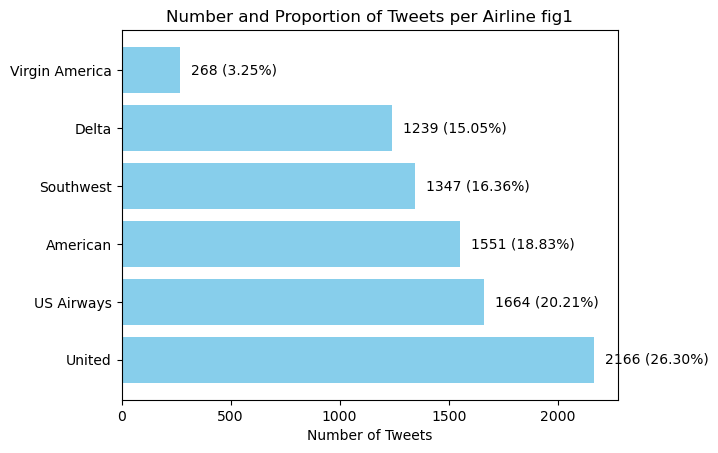

In [43]:
# visualizations
airlines = ["United", "US Airways", "American", "Southwest", "Delta", "Virgin America"]
counts = [united_counts, usairways_counts, american_counts, southwest_counts, delta_counts, virginamerica_counts]
proportions = [united_proportion, usairways_proportion, american_proportion, southwest_proportion, delta_proportion, virginamerica_proportion]


# Combine counts and proportions
counts_and_proportions = [f"{c} ({p:.2%})" for c, p in zip(counts, proportions)]

# Horizontal bar plot
plt.barh(airlines, counts, color='skyblue')
for i, (count, proportion) in enumerate(zip(counts, proportions)):
    plt.text(count + 50, i, f"{count} ({proportion:.2%})", va='center')

plt.xlabel("Number of Tweets")
plt.title("Number and Proportion of Tweets per Airline fig1")
plt.show()



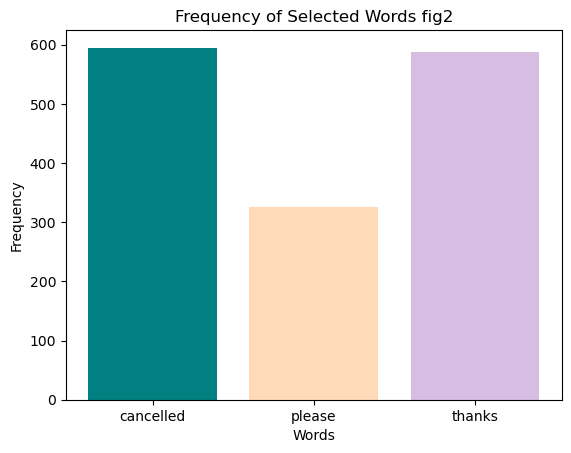

In [44]:
# Words and their counts
words = ["cancelled", "please", "thanks"]
counts = [cancelled_count, please_count, thanks_count]

# Create a bar plot
plt.bar(words, counts, color=['teal', '#FFDAB9', '#D7BDE2'])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency of Selected Words fig2")
plt.show()



In the first figure, fig1, we see the distribution of tweets that tagged or called the different airlines. The airline with the most tweets is United, followed by US Airways, American, Southwest, Delta, and Virgin America. Plotting the proportions of tweets show that the data is not uniform which could be due to popularity, prices, or motivation to go on social media to post about an experience. 

In the second figure, fig2, we have a boxplot of the words: 'cancelled', 'please', and 'thanks'. Words like "thanks" could be positive sentiment indicators whereas "cancelled" could be negative sentiment indicators and suggest a customer had a bad experience or experienced flight disruptions. The boxplot shows that the word "cancelled" has a higher median than the other two words. This could be an indicator that the sentiment of the tweets is negative.

Our visuals tell us there may be some bias in the data. For example in fig1, we see that Virgin America has the least amount of recorded tweets in either sentiment compared to United. Although this is a smaller airline, we need to consider if the proportions are balanced out compared to the airlines instead of just the proportions of all tweets. 

### Models

In [ ]:
#preprocessing the data

pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# Define the hyperparameters grid with expanded range
param_grid = {
    'count__ngram_range': [(1, 1), (1, 2)],        
    'count__max_df': [0.3, 0.5, 0.7],                     
    'count__max_features': [12000, 14000, 16000, 20000],  
    'clf__C': [0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0],      
} 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Best Parameters: {'count__ngram_range': (1, 2), 'count__max_features': 20000, 'count__max_df': 0.3, 'clf__C': 0.5}
Test Accuracy: 0.804735883424408
Production Accuracy: 0.9662416514875531


In [ ]:
# Use RandomizedSearchCV with more iterations for wider search
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=150, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42
)

In [ ]:
# Fit the model with RandomizedSearchCV
random_search.fit(X_train, y_train)

In [ ]:
# Get the best model and calculate accuracy
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy for test and production
test_accuracy = accuracy_score(y_test, y_pred)
production_accuracy = accuracy_score(y_train, best_model.predict(X_train))

# Print the best parameters and accuracy scores
print("Best Parameters:", random_search.best_params_)
print("Test Accuracy:", test_accuracy)
print("Production Accuracy:", production_accuracy) 

## Results

In [ ]:
# report model metrics

## Discussion

### Conclusion